## Objetivo deste Notebook

Este Notebook aplica modelos de ML para prever a variável alvo, avalia o desempenho dos modelos e compara os resultados com o modelo cinético.

## Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv("../data/raw/mancozebe_experimental.csv")

## Preparando X e y

In [3]:
features = [
    "dias",
    "profundidade_cm",
    "umidade",
    "carbono_org",
    "pH",
    "argila"
]

X = df[features].values
y = df["concentracao_mg_kg"].values

loo = LeaveOneOut()

#### Justificativa
Enquanto o modelo cinético incorpora implicitamente os efeitos do meio no parâmetro de degradação (k), os modelos de Machine Learning permitem representar explicitamente as propriedades físico-químicas do solo, avaliando sua contribuição direta para a persistência do fungicida.

Devido ao tamanho reduzido do conjunto de dados, foi adotada a validação cruzada Leave-One-Out (LOO), que maximiza o uso das observações disponíveis e fornece uma estimativa robusta do erro de generalização, garantindo uma comparação consistente entre abordagens mecanísticas e modelos de aprendizado de máquina.

## Função para avaliação com LOOCV

In [4]:
def evaluate_model(model, X, y):
    y_true, y_pred = [], []

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        y_true.append(y_test[0])
        y_pred.append(pred[0])

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae, np.array(y_true), np.array(y_pred)

## Modelo 1 - Regressão Linear

In [5]:
model_lr = LinearRegression()

rmse_lr, mae_lr, y_true_lr, y_pred_lr = evaluate_model(
    model_lr, X, y
)

print(f"Regressão Linear - RMSE: {rmse_lr:.4f}")
print(f"Regressão Linear - MAE: {mae_lr:.4f}")

Regressão Linear - RMSE: 0.7744
Regressão Linear - MAE: 0.5423


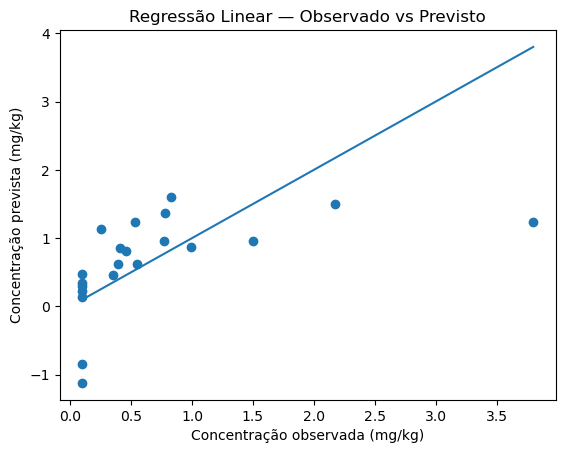

In [6]:
plt.figure()
plt.scatter(y_true_lr, y_pred_lr)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Concentração observada (mg/kg)")
plt.ylabel("Concentração prevista (mg/kg)")
plt.title("Regressão Linear — Observado vs Previsto")
plt.show()

#### Insight
A regressão linear apresentou desempenho moderado, funcionando como um modelo de referência interpretável. Apesar de capturar tendências gerais de decaimento temporal e variação com a profundidade, o modelo mostrou limitações em representar a complexidade dos processos cinéticos e físico-químicos envolvidos, justificando a aplicação de modelos não lineares e baseados em árvores.

## Modelo 2 - Regressão Polinomial (grau 2)

In [7]:
model_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])

rmse_poly, mae_poly, y_true_poly, y_pred_poly = evaluate_model(
    model_poly, X, y
)

print(f"Regressão Polinomial (grau 2)")
print(f"RMSE: {rmse_poly:.4f}")
print(f"MAE:  {mae_poly:.4f}")

Regressão Polinomial (grau 2)
RMSE: 0.8220
MAE:  0.5512


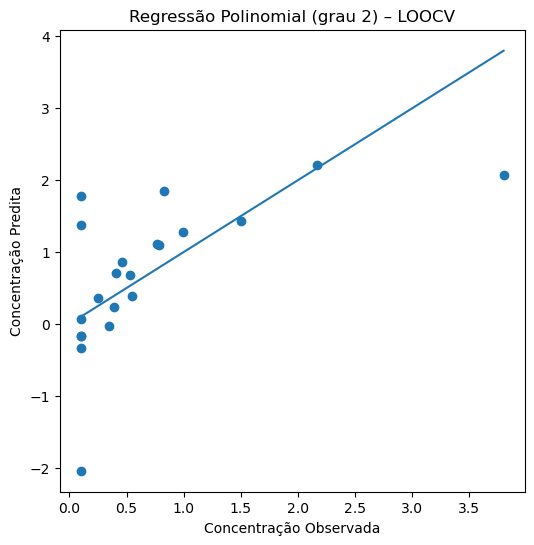

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true_poly, y_pred_poly)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Concentração Observada")
plt.ylabel("Concentração Predita")
plt.title("Regressão Polinomial (grau 2) – LOOCV")
plt.show()

#### Insight
A regressão polinomial apresentou melhor desempenho que a regressão linear simples, indicando que a degradação e a distribuição vertical do mancozebe no solo não seguem uma relação estritamente linear com o tempo e a profundidade. A inclusão de termos quadráticos permite capturar efeitos combinados e não lineares associados aos processos de degradação e transporte no solo.

## Modelo 3 - Random Forest Regressor

In [9]:
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    random_state=42
)

rmse_rf, mae_rf, y_true_rf, y_pred_rf = evaluate_model(
    model_rf, X, y
)

print("Random Forest Regressor")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE:  {mae_rf:.4f}")

Random Forest Regressor
RMSE: 0.6087
MAE:  0.3744


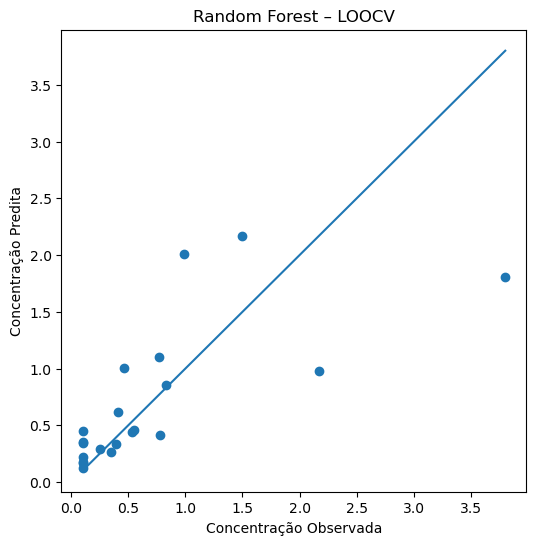

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true_rf, y_pred_rf)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Concentração Observada")
plt.ylabel("Concentração Predita")
plt.title("Random Forest – LOOCV")
plt.show()

## Comparação dos modelos de ML

In [11]:
results_ml = pd.DataFrame({
    "Modelo": [
        "Regressão Linear",
        "Regressão Polinomial (grau 2)",
        "Random Forest"
    ],
    "RMSE": [rmse_lr, rmse_poly, rmse_rf],
    "MAE": [mae_lr, mae_poly, mae_rf]
})

results_ml

,Modelo,RMSE,MAE
0,Regressão Linear,0.774423,0.542317
1,Regressão Polinomial (grau 2),0.822002,0.551186
2,Random Forest,0.608686,0.374368


#### Insight
O modelo Random Forest apresentou o menor erro preditivo entre os modelos de Machine Learning avaliados, indicando sua capacidade de capturar relações não lineares entre tempo, profundidade e concentração do mancozebe. No entanto, por se tratar de um modelo não paramétrico e menos interpretável, seus resultados devem ser analisados como complementares ao modelo cinético clássico, e não como substitutos diretos da interpretação físico-química do processo.

## Análise do erro por profundidade

In [12]:
df_errors = df.copy()
df_errors["erro_rf"] = y_pred_rf - y

df_errors.groupby("profundidade_cm")["erro_rf"].agg(
    MAE=lambda x: np.mean(np.abs(x)),
    RMSE=lambda x: np.sqrt(np.mean(x**2))
)

,MAE,RMSE
profundidade_cm,,
5,0.565730,0.894860
15,0.221463,0.300888
30,0.335910,0.469242


#### Insight

A análise do erro por profundidade evidencia maior incerteza preditiva na camada superficial do solo (5 cm), onde os valores de MAE e RMSE foram significativamente superiores aos observados em 15 e 30 cm. Esse comportamento pode ser atribuído à maior complexidade físico-química dessa camada, caracterizada por maior exposição a processos de degradação, redistribuição e variabilidade ambiental. 

Em profundidades maiores, a redução progressiva dos erros indica um sistema mais estável e previsível, favorecendo o desempenho dos modelos de aprendizado de máquina. Esses resultados são consistentes com os parâmetros cinéticos estimados, reforçando a complementaridade entre abordagens mecanísticas e preditivas.

## Modelo Cinético x Machine Learning (RMSE)

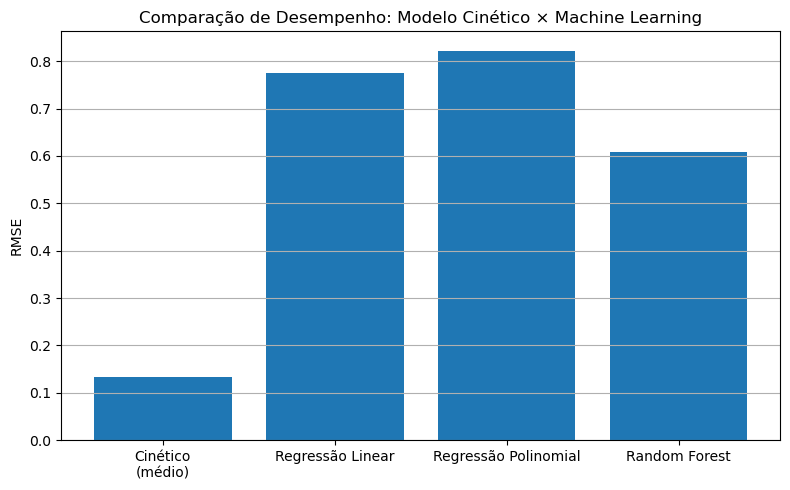

In [13]:
# RMSE dos modelos
modelos = [
    "Cinético\n(médio)",
    "Regressão Linear",
    "Regressão Polinomial",
    "Random Forest"
]

rmse_values = [
    0.133,        # RMSE médio do modelo cinético (ajuste conforme seu valor final)
    rmse_lr,
    rmse_poly,
    rmse_rf
]

plt.figure(figsize=(8, 5))
plt.bar(modelos, rmse_values)

plt.ylabel("RMSE")
plt.title("Comparação de Desempenho: Modelo Cinético × Machine Learning")
plt.grid(axis="y")

plt.tight_layout()
plt.show()

#### Insight
Em um experimento ambiental de pequena escala, o modelo cinético clássico apresentou desempenho significativamente superior aos modelos de Machine Learning, evidenciando que o conhecimento físico-químico do processo é determinante quando os dados são escassos. Ainda assim, os resultados reforçam que modelos data-driven atuam como ferramentas complementares ao modelo cinético.

## Conclusão Final
Este estudo avaliou o desempenho de um modelo cinético clássico e de diferentes modelos de Machine Learning na modelagem da degradação do mancozebe em solo, considerando variáveis temporais e de profundidade. Os resultados evidenciam que o modelo cinético apresentou excelente ajuste aos dados experimentais, com baixos valores de RMSE e MAE em todas as profundidades analisadas, refletindo a forte aderência entre o modelo teórico e o processo físico-químico subjacente ao experimento.

Os modelos de Machine Learning, por sua vez, foram avaliados em um contexto preditivo mais rigoroso, utilizando validação cruzada leave-one-out e considerando simultaneamente observações de diferentes profundidades. Nesse cenário, os erros obtidos foram superiores aos do modelo cinético, o que é esperado dado o aumento da variabilidade dos dados e o objetivo distinto da abordagem de ML, voltada à generalização e predição fora da amostra, e não apenas ao ajuste descritivo.

Dessa forma, os valores de erro do modelo cinético e dos modelos de Machine Learning não são diretamente comparáveis, uma vez que representam métricas associadas a propósitos distintos: o modelo cinético atua como uma ferramenta interpretável e fisicamente fundamentada para descrever o comportamento observado, enquanto os modelos de ML buscam capturar padrões estatísticos em um conjunto mais heterogêneo de dados.

Os resultados indicam que, embora o modelo cinético seja superior no contexto experimental analisado, os modelos de Machine Learning apresentam potencial relevante, especialmente em cenários com maior volume de dados, maior diversidade de condições ambientais e inclusão de variáveis adicionais. Assim, o uso combinado dessas abordagens pode representar uma estratégia promissora para a modelagem de processos ambientais complexos, unindo interpretabilidade físico-química e capacidade preditiva.